In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import islice
import nltk
import csv
import warnings

In [ ]:
nltk.download('punkt')

In [2]:
warnings.filterwarnings("ignore")
color = sns.color_palette()
pd.options.display.max_rows = 4000
%matplotlib inline

In [3]:
#increase the field_size_limit

import sys
import csv
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

In [4]:
trainV = pd.read_csv("training_variants.csv")

In [5]:
trainV.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
trainV.shape

(3321, 4)

In [7]:
def read_this_funky_csv(source):
  # be sure to pass a source object that supports
  # iteration (e.g. a file object, or a list of csv text lines)
  return csv.reader((line.replace('||', '|') for line in source), delimiter='|')

In [8]:
#trainT = pd.read_csv('training_text',sep="||")

fileHandle = open('training_text', 'r')

In [9]:
pipereader = read_this_funky_csv(fileHandle)

In [10]:
fileHandle.seek(0)

In [11]:
columns = next(pipereader)

In [12]:
newcolumns = columns[0].split(',')
newcolumns

['ID', 'Text']

In [13]:
df = pd.DataFrame(columns=newcolumns)

In [14]:
i = 0
ls = []
try:
    while True:
        ls = next(pipereader)
        df.loc[i] = [int(i),ls[1]]
        i += 1
except StopIteration:
    pass
finally:
    del pipereader 

In [15]:
df['ID'] = df['ID'].astype(int)

In [16]:
df.head()   

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [17]:
train_text_df = df.copy()
del df

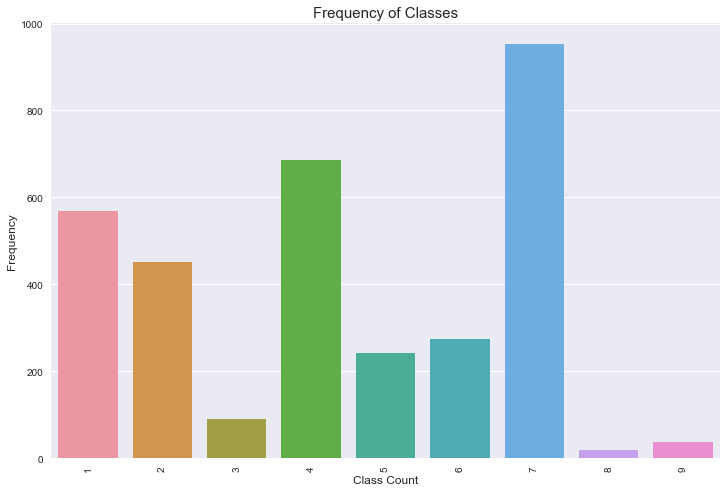

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=trainV)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [19]:
train_genes = trainV.groupby('Gene')['Gene'].count()
print train_genes.head()
print ('\nGene Count {}'.format(len(train_genes)))

Gene
ABL1     26
ACVR1     3
AGO2      5
AKT1     28
AKT2     11
Name: Gene, dtype: int64

Gene Count 264


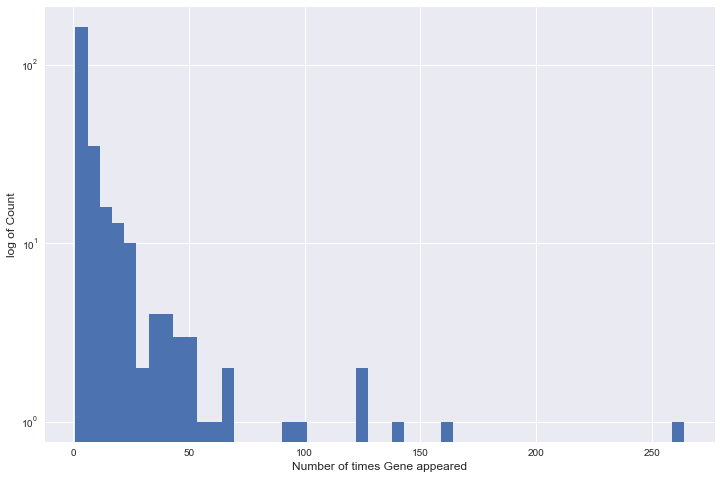

In [20]:
plt.figure(figsize=(12, 8))
plt.hist(train_genes.values, bins=50, log=True)
plt.xlabel('Number of times Gene appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

In [21]:
train_variation = trainV.groupby('Variation')['Variation'].count()
print train_variation.head()
print ('\nVariation Count {}'.format(len(train_variation)))

Variation
1_2009trunc       1
2010_2471trunc    1
256_286trunc      1
3' Deletion       1
385_418del        1
Name: Variation, dtype: int64

Variation Count 2996


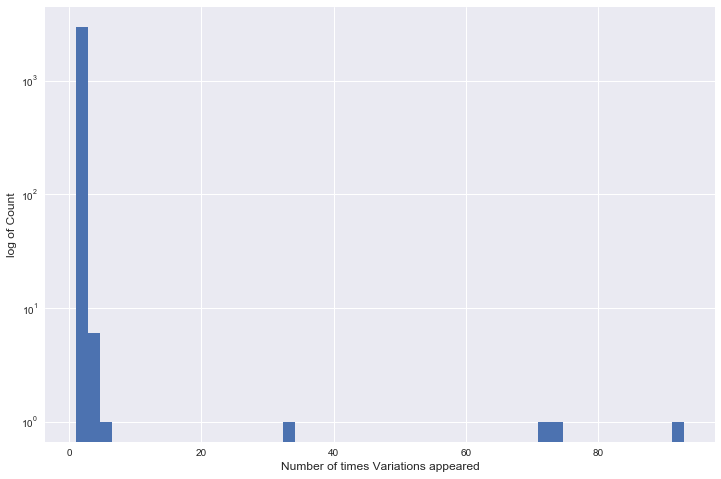

In [22]:
plt.figure(figsize=(12, 8))
plt.hist(train_variation.values, bins=50, log=True)
plt.xlabel('Number of times Variations appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

In [23]:
train_text_df["Text_num_words"] = train_text_df["Text"].apply(lambda x: len(str(x).split()))
train_text_df["Text_num_chars"] = train_text_df["Text"].apply(lambda x: len(str(x)))

In [24]:
train_text_df.head(1)

,ID,Text,Text_num_words,Text_num_chars
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089,39766


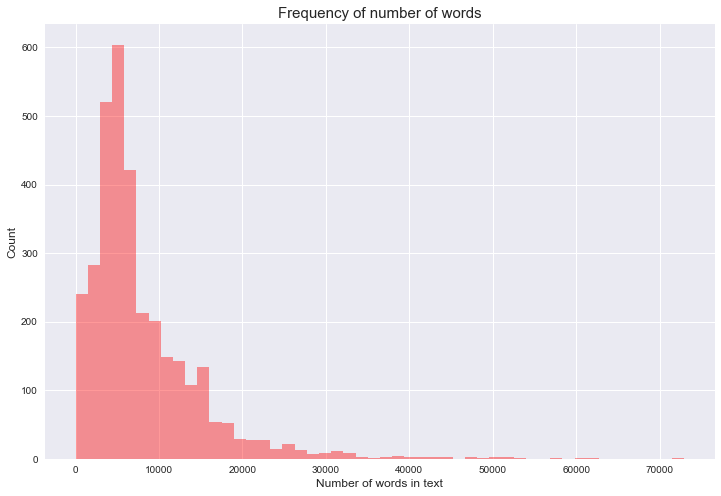

In [25]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text_df.Text_num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

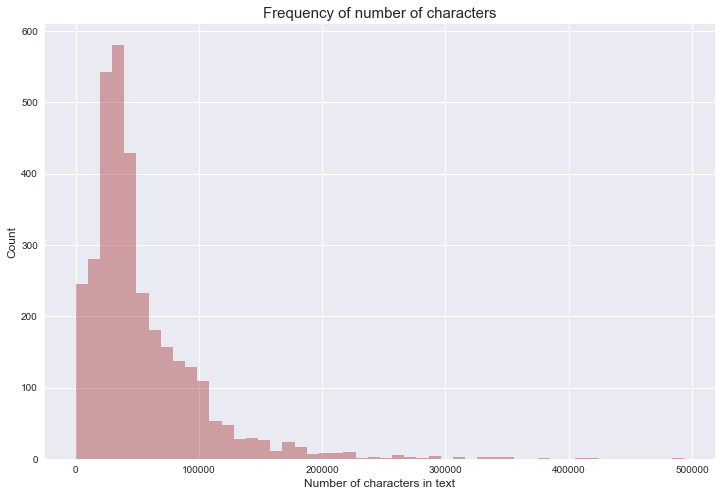

In [26]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text_df.Text_num_chars.values, bins=50, kde=False, color='brown')
plt.xlabel('Number of characters in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of characters", fontsize=15)
plt.show()

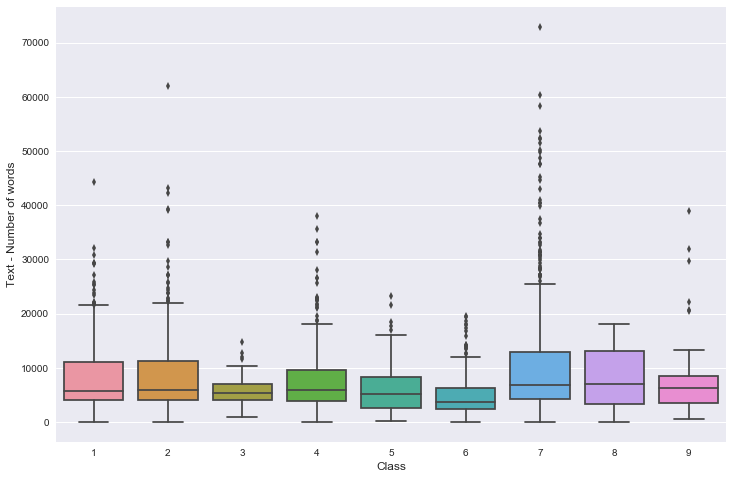

In [27]:
train_df = pd.merge(trainV, train_text_df, on='ID')

plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='Text_num_words', data=train_df)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

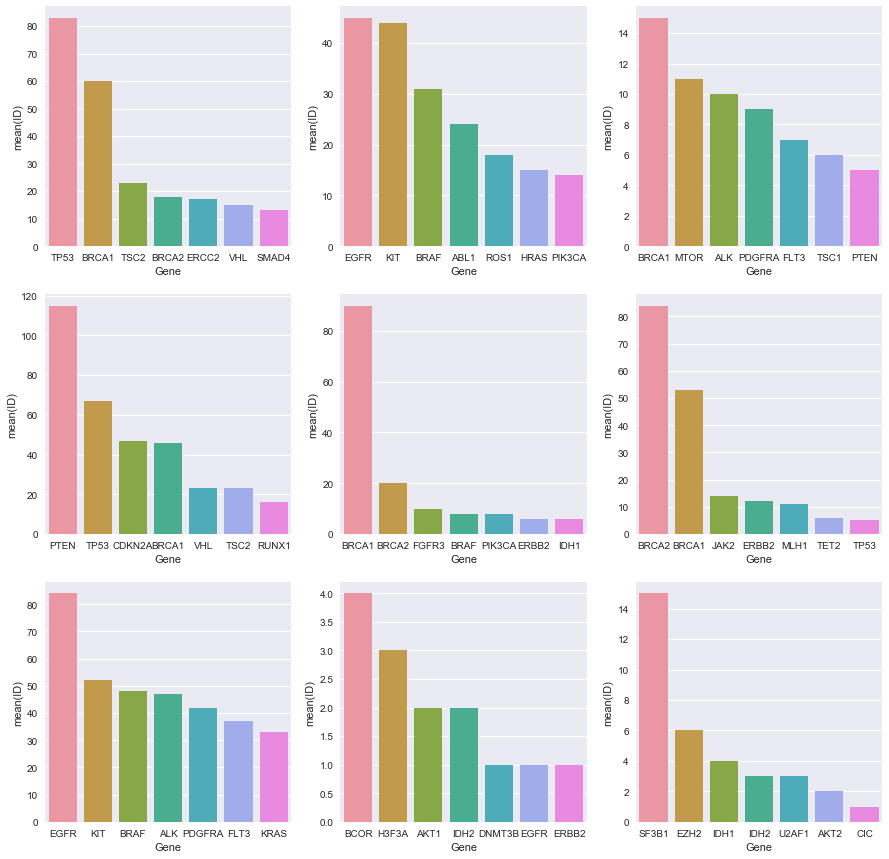

In [28]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = trainV[trainV["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

In [29]:
train_full = trainV.merge(train_text_df, how="inner", left_on="ID", right_on="ID")
train_full[train_full["Class"]==1].head()

,ID,Gene,Variation,Class,Text,Text_num_words,Text_num_chars
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089,39766
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14683,99186
16,16,CBL,Truncating Mutations,1,To determine if residual cylindrical refractiv...,8118,54606
37,37,DICER1,D1709E,1,Sex cord–stromal tumors and germ-cell tumors a...,2710,18611
38,38,DICER1,D1709A,1,Sex cord–stromal tumors and germ-cell tumors a...,2710,18611


In [30]:
train_full.groupby('Class').head()

,ID,Gene,Variation,Class,Text,Text_num_words,Text_num_chars
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089,39766
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5722,36832
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5722,36832
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572,36310
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202,41429
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,6202,41429
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,6202,41429
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14683,99186
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...,11923,80072
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...,5721,38643


In [31]:
count_grp = train_full.groupby('Class')["Text_num_words"]

In [32]:
count_grp.describe()

Class       
1      count      568.000000
       mean      7795.556338
       std       5912.948769
       min          1.000000
       25%       4112.000000
       50%       5674.000000
       75%      11080.250000
       max      44257.000000
2      count      452.000000
       mean      8440.621681
       std       7181.433679
       min         98.000000
       25%       4077.750000
       50%       5989.000000
       75%      11346.500000
       max      61923.000000
3      count       89.000000
       mean      5600.337079
       std       2531.213808
       min        862.000000
       25%       4078.000000
       50%       5325.000000
       75%       7047.000000
       max      14688.000000
4      count      686.000000
       mean      7410.737609
       std       5465.348700
       min         53.000000
       25%       3971.000000
       50%       5998.000000
       75%       9646.750000
       max      38070.000000
5      count      242.000000
       mean      5780.000000
 

In [33]:
train_full[train_full['Text_num_words']==1.0]

,ID,Gene,Variation,Class,Text,Text_num_words,Text_num_chars
1109,1109,FANCA,S1088F,1,null,1,5
1277,1277,ARID5B,Truncating Mutations,1,null,1,5
1407,1407,FGFR3,K508M,6,null,1,5
1639,1639,FLT1,Amplification,6,null,1,5
2755,2755,BRAF,G596C,7,null,1,5


In [34]:
train_full[train_full['Text_num_words']<500.0]

,ID,Gene,Variation,Class,Text,Text_num_words,Text_num_chars
140,140,EGFR,I491M,5,The accurate determination of perfluoroalkyl s...,430,2927
145,145,EGFR,K467T,2,The accurate determination of perfluoroalkyl s...,430,2927
220,220,EGFR,S492R,8,Antibodies against epidermal growth factor rec...,97,746
259,259,EGFR,S464L,2,The accurate determination of perfluoroalkyl s...,430,2927
344,344,CDH1,A617T,4,E-cadherin is involved in the formation of cel...,187,1317
346,346,CDH1,A634V,4,E-cadherin is involved in the formation of cel...,187,1317
348,348,CDH1,T340A,4,E-cadherin is involved in the formation of cel...,187,1317
353,353,EP300,Y1414C,4,Esophageal squamous cell carcinoma (ESCC) is o...,173,1146
360,360,EP300,P1502L,4,Esophageal squamous cell carcinoma (ESCC) is o...,173,1146
418,418,TP53,R110L,1,Many p53 missense mutations possess dominant-n...,167,1238


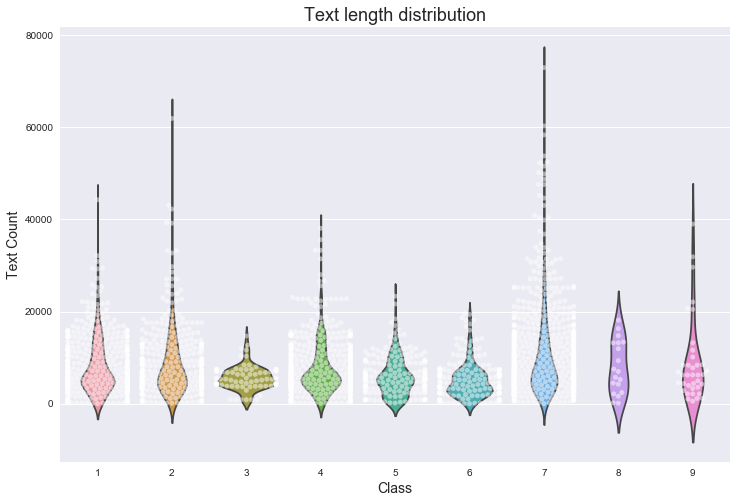

In [35]:
plt.figure(figsize=(12,8))
gene_count_grp = train_full.groupby('Gene')['Text_num_words'].sum().reset_index()
sns.violinplot(x="Class", y="Text_num_words", data=train_full, inner=None)
sns.swarmplot(x="Class", y="Text_num_words", data=train_full, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

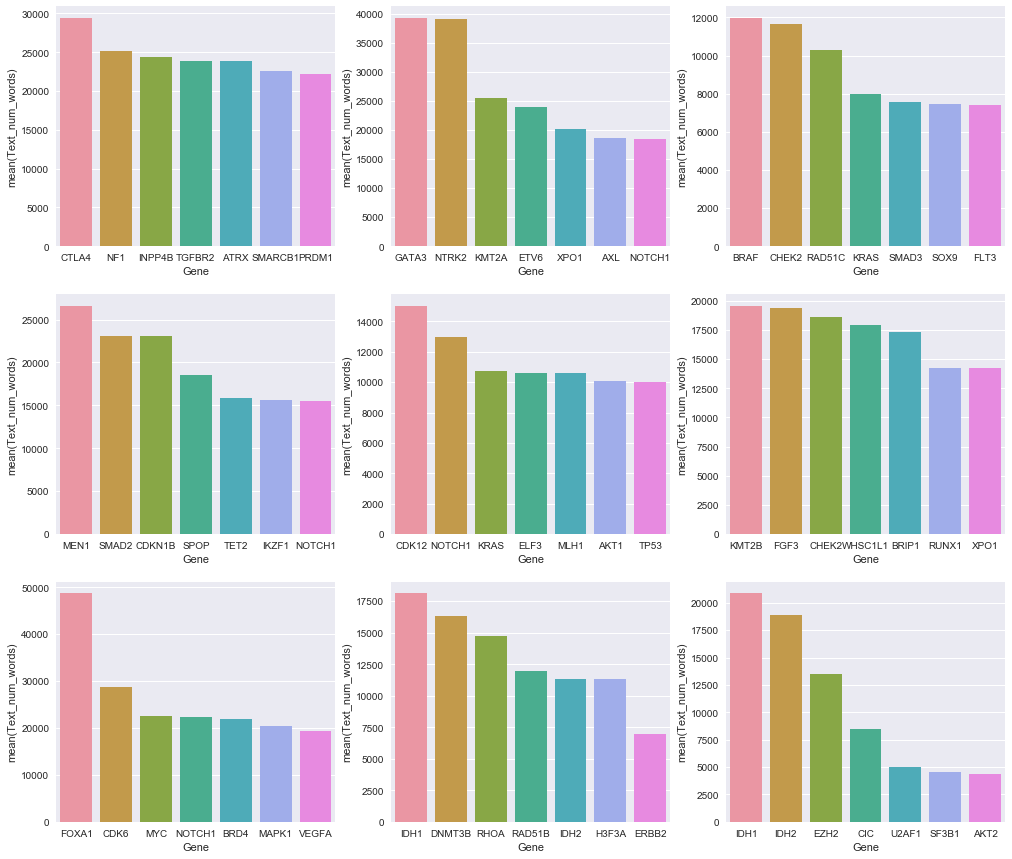

In [36]:
ig, axs = plt.subplots(ncols=3, nrows=3, figsize=(17,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_full[train_full["Class"]==((i*3+j)+1)].groupby('Gene')['Text_num_words'].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_num_words', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_num_words", data=sorted_gene_group_top_7, ax=axs[i][j])

In [37]:
def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray() #returns rows in term-document matrix that match the class at the grp_ids index in y
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0  # set all the cells with values less than the threshold to be zero
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    
    #min_tfidf : threshold of minimum value required for a cell in term-document matrix
    
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(9, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Gene", labelpad=16, fontsize=16)
        ax.set_title("Class = " + str(df.label), fontsize=18)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [43]:
tfidf = TfidfVectorizer(
            min_df=5, max_features=16000, strip_accents='unicode', lowercase=True,
            analyzer='word', token_pattern=r'\w+', use_idf=True, 
            smooth_idf=True, sublinear_tf=True, stop_words = 'english'
        ).fit(train_full["Text"])

# time taken : approx 3 mins

In [44]:
Xtr = tfidf.fit_transform(train_full["Text"])

In [47]:
Xtr.toarray()

array([[ 0.02395434,  0.        ,  0.03969422, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03291553,  0.        ,  0.02664028, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03291553,  0.        ,  0.02664028, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.00662439,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00765313,  0.        ,  0.01150926, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0169606 ,  0.        ,  0.00828281, ...,  0.        ,
         0.        ,  0.        ]])

In [48]:
Xtr.shape

(3321, 16000)

In [49]:
train_full['Text'].shape

(3321,)

In [51]:
y = train_full["Class"]

In [130]:
features = tfidf.get_feature_names()

In [136]:
top_dfs = top_feats_by_class(Xtr, y, features)

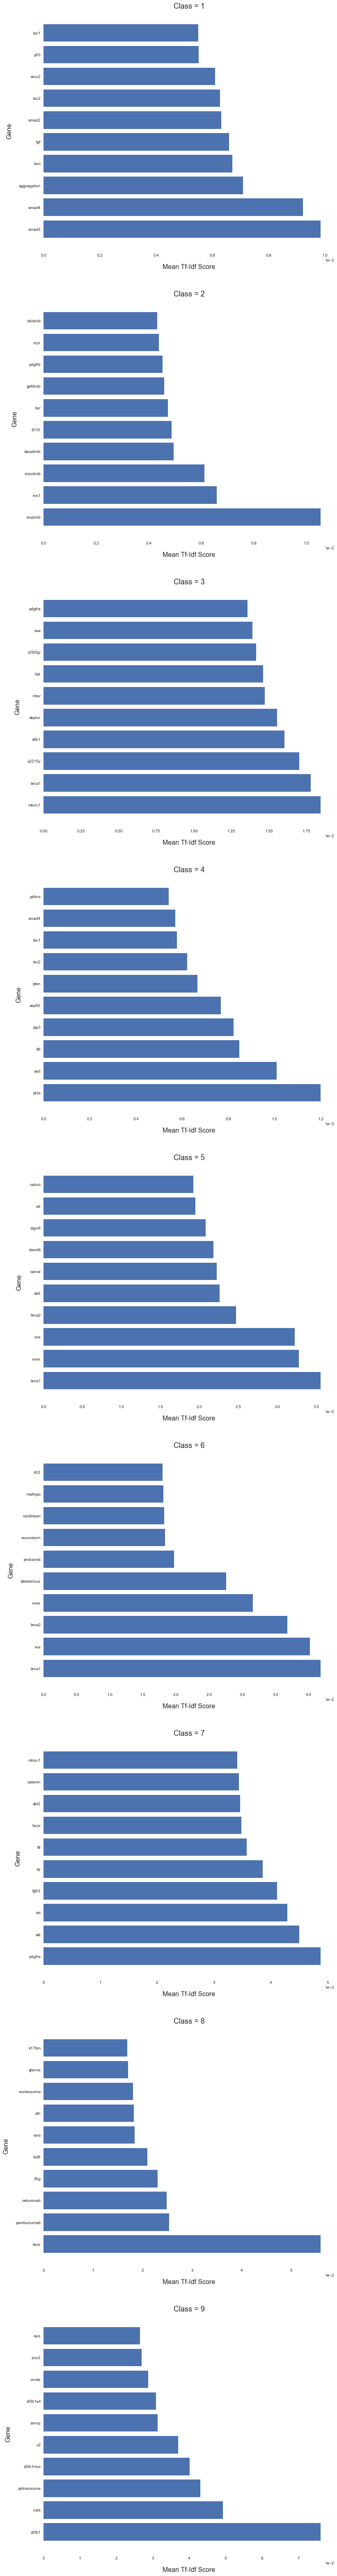

In [138]:
plot_tfidf_classfeats_h(top_dfs)

In [142]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)   

In [154]:
#count_vectorizer.fit_transform(train_full['Text'])

<3321x255957 sparse matrix of type '<type 'numpy.int64'>'
	with 4969924 stored elements in Compressed Sparse Row format>

In [157]:
len(count_vectorizer.vocabulary_)

255957

In [168]:
#Print any 10 elements of a dictionary

dict(islice(count_vectorizer.vocabulary_.iteritems(), 0, 5))

{u'27\xa7': 25552,
 u'5\u2032-ctcctcaaaacccggagactt-3\u2032': 39970,
 u'g03/073': 116134,
 u'k14-positive': 141727,
 u'pu-h71': 198415}

In [169]:
bag_of_words = count_vectorizer.fit_transform(train_full['Text'])

In [170]:
bag_of_words.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [172]:
bag_of_words.toarray().shape

(3321, 255957)

** Rough work below this **

In [ ]:
#top_feats_by_class(Xtr, y, features)
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray() 
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [128]:
labels = np.unique(y)
x = np.ones((5,5))
x[0] = 5
x.shape

(5, 5)